# Take sample of tweets based on classification scores for Covid-19 myths

@authors: Jaren Haber, Alexander Chen, Kornraphop Kawintiranon<br>
@affiliation: Massive Data Institute, McCourt School of Public Policy, Georgetown University<br>
@date: November 2, 2020

'''
Uses classifiers trained on labeled tweets (about a myth vs. not) to select a sample of 150 tweets for labeling on MTurk. Data source is tweets with hashtags related to Covid-19. For the first batch using this script, 90% of these selected tweets are predicted to be of the minority class for that myth: e.g., no on weather, yes on disinfectants, or yes on home remedies. The remaining 10% are from majority class, which are easier to predict in our skewed first batch of data. Future batches may use a more balanced sampling procedure. 
'''

## Initialize

In [4]:
# Install anything not already in server
#!pip install gcsfs
# !pip install nltk
# !pip install emoji
#!pip install --upgrade scikit-learn # need to update sklearn for Jaren's VM

import nltk
nltk.download('punkt')
nltk.download('wordnet')

     |████████████████████████████████| 1.5 MB 11.7 MB/s eta 0:00:01
     |████████████████████████████████| 114 kB 72.8 MB/s eta 0:00:01
     |████████████████████████████████| 159 kB 64.4 MB/s eta 0:00:01
     |████████████████████████████████| 324 kB 73.4 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 5.5 MB/s  eta 0:00:01
     |████████████████████████████████| 155 kB 75.0 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 7.5 MB/s  eta 0:00:01
     |████████████████████████████████| 1.4 MB 12.4 MB/s eta 0:00:01
     |████████████████████████████████| 738 kB 61.4 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434677 sha256=830264f3107a1afd99d76d7ec165cad3c79f6e83a47d449872ad8ffdd45d8f3f
  Stored in directory: /home/jovyan/.cache/pip/wheels/ff/d5/7b/f1fb4e1e1603b2f01c2424dd60fbcc50c12ef918bafc44b155
Successfully built nltk
     |████████████████████████████████| 51 kB 6.9 MB/s  eta 0:00:01
  Created wheel for emoji: fi

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [1]:
######################################################
# Import libraries
######################################################

import pandas as pd
import numpy as np
import re, csv, os
from datetime import date
from random import sample
from collections import Counter
import gcsfs # for quick loading of data from gcloud
from tqdm import tqdm
tqdm.pandas()

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

import joblib
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import emoji

/opt/conda/lib/python3.8/site-packages/tqdm/std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
######################################################
# Define filepaths
######################################################

bucket_fp = 'gs://project_coronavirus/raw/hashtag/'

dis_mod_fp = '../models/tweet_classifier_disinfectants.joblib'
rem_mod_fp = '../models/tweet_classifier_home_remedies.joblib'
wth_mod_fp = '../models/tweet_classifier_weather.joblib'

dis_vec_fp = '../models/vectorizer_disinfectants.joblib'
rem_vec_fp = '../models/vectorizer_home_remedies.joblib'
wth_vec_fp = '../models/vectorizer_weather.joblib'

n_sample = 150
thisday = date.today().strftime("%d%m%y")

dis_sam_fp = f'../data/sample_{str(n_sample)}_tweets_disinfectants_{str(thisday)}.csv'
rem_sam_fp = f'../data/sample_{str(n_sample)}_tweets_home_remedies_{str(thisday)}.csv'
wth_sam_fp = f'../data/sample_{str(n_sample)}_tweets_weather_{str(thisday)}.csv'

In [3]:
def read_tweets (dirname, 
                 num_rand_files = 0, 
                 start_week_num = -1, 
                 end_week_num = 0, 
                 levels = 1, 
                 nrows = 50, 
                 language = 'en'):
    
    """
    Read latest Twitter data from JSON files. 
    Options: take random number of files from each folder, 
    look only at folders for weeks within specified range, and/or 
    read files in single folder (1 level) or folder of folders (2 levels).
    
    Args:
        dirname: folder in Google Cloud Compute Server where Twitter JSON files live
        num_rand_files: number of random files to draw from each folder. Useful when randomly sampling from files with lots of tweets
        start_week_num: first week in range (to take tweets from), inclusive
        end_week_num: last week in range (to take tweets from), inclusive
        levels: number of folders in hierarchy ('dirname/file1, dirname/file2, etc.' = one level)
        nrows: number of tweets to read from file
        language: filter to only tweets in this language
    Returns:
        df: DataFrame with loaded in Twitter data
    """
    
    fs = gcsfs.GCSFileSystem(project="MDI-1", token="cloud")
    
    if levels == 2: # two levels (multiple folders)
        files = []
        folders = [folder for folder in fs.ls(dirname) 
                   if folder != dirname 
                   and os.path.join("gs://", folder) != dirname] # don't keep duplicate folders = same as dirname
        
        for folder in folders:
            # only process folders where: start_week_num < week_number < end_week_num
            week_num = int(folder.split('/')[-1][9:]) # get week number: last part of file path, anything after '2020-week'
            if week_num < start_week_num or (end_week_num > 0 and week_num > end_week_num):
                continue # skip if not in week range
            
            # for folders of weeks in desired range, get their files
            listf = fs.ls(os.path.join("gs://", folder)) # get list of files in this folder
            listf = [re.sub(r"#", r"%23", file) for file in listf] # in each file name, replace '#' with '%23' so pandas can read it
            if num_rand_files > 0:
                listf = sample(listf, num_rand_files) # get specified number of random files
            files.extend(listf) # add each file to list
            files = [x for x in files if x.endswith(".json") or x.endswith(".json.gz")]
            
    else: # one level (just one folder)
        files = fs.ls(dirname)
        files = [x for x in files if x.endswith(".json") or x.endswith(".json.gz")]
        if num_rand_files > 0:
            files = sample(listf, num_rand_files) # get specified number of random files
    
    print(f"Reading in tweets from {len(files)} JSON files...")
    
    # Load and merge files as DFs
    dfs = []
    for f in tqdm(files):
        #print("gs://{}".format(f))
        thisdf = pd.read_json("gs://{}".format(f), nrows = nrows, lines=True)
        if 'lang' in thisdf.columns:
            thisdf['language'] = thisdf['lang'] # funnel 'lang' to 'language' column
            thisdf.drop(columns = 'lang', inplace = True) # erase 'lang' column (now a duplicate)
        thisdf = thisdf[thisdf['language']==language] # Filter to only tweets in language
        dfs.append(thisdf)
    df = pd.concat(dfs)
    
    return df

## Load & inspect data

In [4]:
######################################################
# Load models
######################################################

dis_mod = joblib.load(dis_mod_fp)
rem_mod = joblib.load(rem_mod_fp)
wth_mod = joblib.load(wth_mod_fp)

In [16]:
######################################################
# Load and inspect the data
######################################################

df = read_tweets(bucket_fp, 
                 num_rand_files = 1, 
                 start_week_num = 14, 
                 end_week_num = 35, 
                 levels = 2, 
                 nrows = 1000,
                 language='en')

print('Number of rows (tweets) and cols in DF:', str(df.shape))
print()
print('Columns in tweets DF:\n', str(df.columns))
print()

# See examples of two tweets. 
# Have usernames and URLs already been replaced?
print("Example tweet 1:\n", df['full_text'].iloc[0])
print()
print("Example tweet 2:\n", df['full_text'].iloc[10])
print()

df.head(5)

  0%|          | 0/21 [00:00<?, ?it/s]

Reading in tweets from 21 JSON files...


100%|██████████| 21/21 [00:54<00:00,  2.58s/it]

Number of rows (tweets) and cols in DF: (6016, 61)

Columns in tweets DF:
 Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'metadata', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'retweeted_status', 'is_quote_status',
       'quoted_status_id', 'quoted_status_id_str', 'retweet_count',
       'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive',
       'quoted_status', 'extended_entities', 'language', 'conversation_id',
       'date', 'time', 'timezone', 'user_id', 'username', 'name', 'tweet',
       'mentions', 'urls', 'photos', 'replies_count', 'retweets_count',
       'likes_count', 'hashtags', 'cashtags', 'link', 'retweet', 'quote_url',
       'video', 'thumbnail', 'near', 'user_rt_id', 'user_rt', 'retweet_id',
       'reply_to', 'retweet_

,created_at,id,id_str,full_text,truncated,display_text_range,entities,metadata,source,in_reply_to_status_id,...,thumbnail,near,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,2020-04-04 00:26:15+00:00,1246232579797323779,1.246233e+18,RT @marxistJorge: NY governor has signed an ex...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-04-04 00:26:14+00:00,1246232575640629248,1.246233e+18,'We will starve': Zimbabwe's poor full of misg...,False,"[0, 237]","{'hashtags': [{'text': 'Covid_19', 'indices': ...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2020-04-04 00:26:14+00:00,1246232574583812096,1.246233e+18,"To try to be healthy during this #Quarantine, ...",False,"[0, 191]","{'hashtags': [{'text': 'Quarantine', 'indices'...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-04-04 00:26:14+00:00,1246232573396815874,1.246233e+18,RT @DrOniBee: The ability to do #SocialDistanc...,False,"[0, 140]","{'hashtags': [{'text': 'SocialDistancing', 'in...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2020-04-04 00:26:09+00:00,1246232556325851136,1.246233e+18,White rabbit is everywhere!! #Adrenochrome #Co...,False,"[0, 86]","{'hashtags': [{'text': 'Adrenochrome', 'indice...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocess text data

In [17]:
######################################################
# Tweet Preprocessing
######################################################

def process_tweets(tweet):
    '''
    Preprocesses raw text of a tweet by lower-casing, stripping whitespace, 
    
    TO DO: Check whether URLs and usernames are already replaced with signifers in this data. If not, change cleaning procedure to handle this case and incorporate parameter to scope to both situations.
    TO DO: Delete any retweets.
    
    args:
        tweet: raw text of a tweet
    '''
    
    # Skip retweets and non-strings
    retweet_pattern = r'^RT\s+' # recognize retweets by starting with 'RT'
    if not isinstance(tweet, str) or re.search(retweet_pattern, tweet):
        return ''
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Repair hashtag and remove newline character
    # from text_helpers.tweet_text_cleanup
    tweet = tweet.replace("# ", "#")
    tweet = tweet.replace("\n", " ")
    
    # remove URLs and @mentions
    # Simple regular expression to match URLs starting with `https` or `http`
    # More complex regex an be found here: https://mathiasbynens.be/demo/url-regex
    url_regex = r"https?://\S*"
    # Regex to match mentions
    mention_regex = r"@\S*"
    tweet = re.sub(url_regex, "", tweet)
    tweet = re.sub(mention_regex, "", tweet)
        
    # Remove additional white spaces
    whitespace_pattern = r'\s+'
    tweet = re.sub(whitespace_pattern, ' ', tweet) # strip whitespaces in between words
    tweet = tweet.strip() # strip whitespaces at start & end
    
    # Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    # Remove emojis
    tweet = emoji.get_emoji_regexp().sub(u'', tweet)
    
    # Lemmatization
    tweet = tweet.split()
    tweet = ' '.join([stemmer.lemmatize(word) for word in tweet])
        
    return tweet

print("Preprocessing tweets...")
df['text_cleaned'] = df['full_text'].progress_apply(lambda x: process_tweets(x))
df = df[df['text_cleaned']!=''] # Filter to only non-empty text_cleaned tweets

  6%|▌         | 360/6016 [00:00<00:01, 3582.98it/s]

Preprocessing tweets...


100%|██████████| 6016/6016 [00:01<00:00, 3429.95it/s]


In [19]:
# Take a look at two (probably different) tweets post-preprocessing
print("Example tweet 1 (cleaned):\n", df['text_cleaned'].iloc[0])
print()
print("Example tweet 2 (cleaned):\n", df['text_cleaned'].iloc[10])
print()

Example tweet 1 (cleaned):
 'we will starve': zimbabwe's poor full of misgiving over covid-19 lockdown - "zimbabwe ha been plunged into a 21-day national lockdown to curb the spread of covid_19, after eight confirmed cases, and one death."

Example tweet 2 (cleaned):
 in other words, a typical weekend! stayhome isolationmode waybackwithkmac keepyourdistance washyourhands covid_19 quarantine



In [20]:
# Check out vocab size after cleaning
# Add words from each cleaned tweet to empty list:
tweet_tokens_cleaned = []
print("Tokenizing words for counting purposes...")
df['text_cleaned'].progress_apply(lambda x: tweet_tokens_cleaned.extend(word_tokenize(x))) # add each word to tokens list

print('Vocabulary size for preprocessed tweets:', str(len(set(tweet_tokens_cleaned))))

# Check out most frequent words in preprocessed text
freq = Counter(tweet_tokens_cleaned)
print('20 most frequent words in cleaned tweets:')
freq.most_common(20)

 10%|▉         | 154/1589 [00:00<00:00, 1535.10it/s]

Tokenizing words for counting purposes...


100%|██████████| 1589/1589 [00:00<00:00, 1842.68it/s]

Vocabulary size for preprocessed tweets: 8016
20 most frequent words in cleaned tweets:


[('.', 1362),
 ('the', 1122),
 (',', 883),
 ('to', 876),
 ('and', 718),
 ('in', 704),
 ('covid19', 626),
 ('of', 586),
 ('a', 575),
 ('coronavirus', 574),
 ('covid', 555),
 ('case', 509),
 (':', 502),
 ('new', 475),
 ('coronavirusoutbreak', 366),
 ('is', 361),
 ('coronavirusupdate', 329),
 ('for', 326),
 ('death', 289),
 ('you', 274)]

In [ ]:
# ######################################################
# # Vectorize text
# ######################################################

# # Use TFIDF weighted DTM because does better overall than unweighted
# #vectorizer = CountVectorizer(max_features=10000, min_df=1, max_df=0.8, stop_words=stopwords.words('english')) # DTM
# vectorizer = TfidfVectorizer(max_features=2494, min_df=1, max_df=0.8, stop_words=stopwords.words('english')) # TFIDF

# # creates sparse DTM X
# # use X.toarray() to get with zero representation

# tweets = [] # empty list to add tweets to
# df['text_cleaned'].apply(lambda x: tweets.append(x)) # add tweet from each row of DF

# X = vectorizer.fit_transform(tweets)

# print('Number of features in vectorizer (total vocabulary):', len(vectorizer.get_feature_names()))
# print()

# print(vectorizer.get_feature_names()[::500]) # get every 500th word

In [21]:
#####################################################
# Load vectorizers and vectorize tweets
######################################################

dis_vec = joblib.load(dis_vec_fp)
rem_vec = joblib.load(rem_vec_fp)
wth_vec = joblib.load(wth_vec_fp)

# dis_tweets, rem_tweets, wth_tweets = [], [], [] # empty list to add tweets to

# X_dis = dis_vec.transform(tqdm(tweets))
# X_rem = rem_vec.transform(tqdm(tweets))
# X_wth = wth_vec.transform(tqdm(tweets))

In [ ]:
# dis_df = df[['id','full_text', 'text_cleaned']]
# rem_df = df[['id','full_text', 'text_cleaned']]
# wth_df = df[['id','full_text', 'text_cleaned']]

In [22]:
# Clean up: Filter to key columns
final_df = df[['id','full_text','text_cleaned']]
final_df

,id,full_text,text_cleaned
3,1246232575640629248,'We will starve': Zimbabwe's poor full of misg...,'we will starve': zimbabwe's poor full of misg...
6,1246232574583812096,"To try to be healthy during this #Quarantine, ...","to try to be healthy during this quarantine, i..."
17,1246232556325851136,White rabbit is everywhere!! #Adrenochrome #Co...,white rabbit is everywhere!! adrenochrome covi...
22,1246232549778694150,"Moreover, Bolsonaro pointed out that “anyone c...","moreover, bolsonaro pointed out that “anyone c..."
24,1246232548486733824,Before a #TriMet employee can receive #PPE @tr...,before a trimet employee can receive ppe and e...
...,...,...,...
970,1297669866774724609,#Japanese Prime Minister #ShinzoAbe is plannin...,japanese prime minister shinzoabe is planning ...
974,1297674283456647174,In your campaign @DrBiden is the Eternal spiri...,in your campaign is the eternal spirit of paul...
975,1297673072674209798,"Hypocritical.\n\nRules for thee, not for me.\n...","hypocritical. rule for thee, not for me. china..."
982,1297676871421898754,@ChineseEmbinUS The Eternal Spirit of Paul Wel...,the eternal spirit of paul wellstone is there ...


## Compute predictions for each tweet using model

In [23]:
def compute_prediction(tweet_text, vectorizer_model, class_model):
    '''
    Predicts the label for an input tweet using a given model trained to classify Covid-19-related myths in tweets. 
    
    Args:
        tweet_text: array of preprocessed text of a single tweet
        vectorizer_model: fitted text vectorizer
        class_model: trained classification model
    Returns:
        label: label for tweet_text predicted by model, false for tie
        prob: probability for label
    '''
    
    X = vectorizer_model.transform(tweet_text)
    probabilities = class_model.predict_proba(X)
    
    label = 'no'
    prob_no = probabilities[0][0]
    prob_yes = probabilities[0][1]
    
    # predicted label is one with greater probability
    if probabilities[0][0] < probabilities[0][1]:
        label = 'yes'
        
    return label, prob_yes, prob_no

# TODO: Combine two lines so no need to call compute_prediction twice
final_df[['prediction_dis','prediction_dis_prob_yes','prediction_dis_prob_no']] = final_df['text_cleaned'].progress_apply(lambda x: pd.Series(compute_prediction([x], dis_vec, dis_mod)))
final_df[['prediction_rem','prediction_rem_prob_yes','prediction_rem_prob_no']] = final_df['text_cleaned'].progress_apply(lambda x: pd.Series(compute_prediction([x], rem_vec, rem_mod)))
final_df[['prediction_wth','prediction_wth_prob_yes','prediction_wth_prob_no']] = final_df['text_cleaned'].progress_apply(lambda x: pd.Series(compute_prediction([x], wth_vec, wth_mod)))

final_df

100%|██████████| 1589/1589 [02:41<00:00,  9.86it/s]
/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
100%|██████████| 1589/1589 [02:45<00:00,  9.60it/s]


,id,full_text,text_cleaned,prediction_dis,prediction_dis_prob_yes,prediction_dis_prob_no,prediction_rem,prediction_rem_prob_yes,prediction_rem_prob_no,prediction_wth,prediction_wth_prob_yes,prediction_wth_prob_no
3,1246232575640629248,'We will starve': Zimbabwe's poor full of misg...,'we will starve': zimbabwe's poor full of misg...,no,0.136,0.864,no,0.048,0.952,yes,0.9870,0.0130
6,1246232574583812096,"To try to be healthy during this #Quarantine, ...","to try to be healthy during this quarantine, i...",no,0.162,0.838,no,0.004,0.996,yes,0.9972,0.0028
17,1246232556325851136,White rabbit is everywhere!! #Adrenochrome #Co...,white rabbit is everywhere!! adrenochrome covi...,no,0.031,0.969,no,0.004,0.996,yes,0.9962,0.0038
22,1246232549778694150,"Moreover, Bolsonaro pointed out that “anyone c...","moreover, bolsonaro pointed out that “anyone c...",no,0.055,0.945,no,0.004,0.996,yes,0.9912,0.0088
24,1246232548486733824,Before a #TriMet employee can receive #PPE @tr...,before a trimet employee can receive ppe and e...,no,0.035,0.965,no,0.002,0.998,yes,0.9960,0.0040
...,...,...,...,...,...,...,...,...,...,...,...,...
970,1297669866774724609,#Japanese Prime Minister #ShinzoAbe is plannin...,japanese prime minister shinzoabe is planning ...,no,0.053,0.947,no,0.179,0.821,yes,0.9972,0.0028
974,1297674283456647174,In your campaign @DrBiden is the Eternal spiri...,in your campaign is the eternal spirit of paul...,no,0.034,0.966,no,0.008,0.992,yes,0.9962,0.0038
975,1297673072674209798,"Hypocritical.\n\nRules for thee, not for me.\n...","hypocritical. rule for thee, not for me. china...",no,0.042,0.958,no,0.007,0.993,yes,0.9042,0.0958
982,1297676871421898754,@ChineseEmbinUS The Eternal Spirit of Paul Wel...,the eternal spirit of paul wellstone is there ...,no,0.035,0.965,no,0.008,0.992,yes,0.9962,0.0038


## Visualize distributions of labels

<AxesSubplot:>

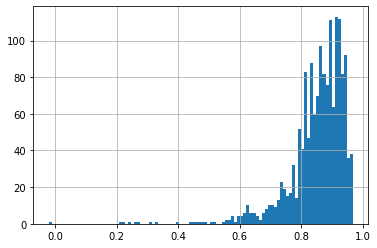

In [31]:
(final_df['prediction_dis_prob_no'] - final_df['prediction_dis_prob_yes']).hist(bins=100) # differences

<AxesSubplot:>

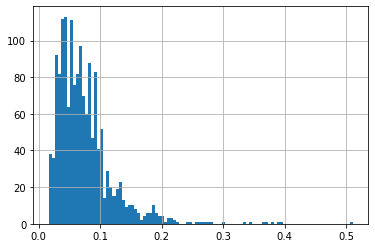

In [35]:
final_df['prediction_dis_prob_yes'].hist(bins=100) # minority class

In [72]:
threshold = 0.125
prop = (len(final_df[final_df['prediction_dis_prob_yes'] > threshold])/len(final_df))*100
print(f'{str(round(prop,3))}% of cases are above {str(threshold)}')

10.321% of cases are above 0.125


prediction_dis
no    1510
dtype: int64


Text(0, 0.5, 'count')

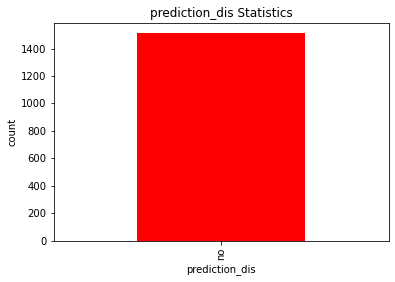

In [38]:
print(final_df.groupby('prediction_dis').size())
colors = ['red', 'green']
dis_plot = final_df.groupby('prediction_dis').size()\
        .plot(kind='bar',title='prediction_dis Statistics', color = colors)
dis_plot.set_ylabel('count')

<AxesSubplot:>

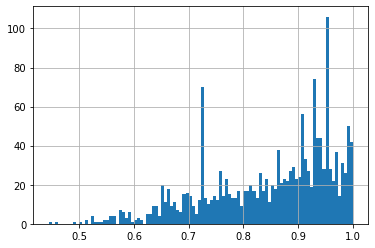

In [32]:
(final_df['prediction_rem_prob_no'] - final_df['prediction_rem_prob_yes']).hist(bins=100) # differences

<AxesSubplot:>

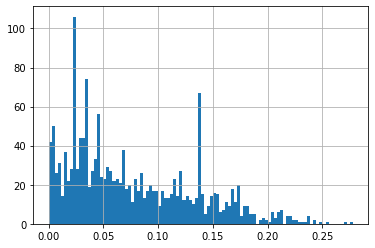

In [36]:
final_df['prediction_rem_prob_yes'].hist(bins=100) # minority class

In [68]:
threshold = 0.155
prop = (len(final_df[final_df['prediction_rem_prob_yes'] > threshold])/len(final_df))*100
print(f'{str(round(prop,3))}% of cases are above {str(threshold)}')

10.636% of cases are above 0.155


prediction_rem
no    1510
dtype: int64


Text(0, 0.5, 'count')

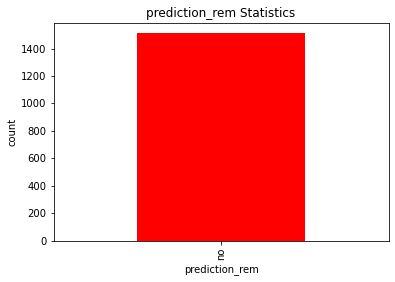

In [32]:
print(final_df.groupby('prediction_rem').size())
colors = ['red', 'green']
rem_plot = final_df.groupby('prediction_rem').size()\
        .plot(kind='bar',title='prediction_rem Statistics', color = colors)
rem_plot.set_ylabel('count')

<AxesSubplot:>

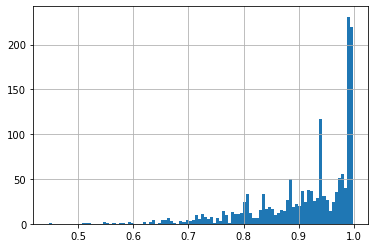

In [33]:
(final_df['prediction_wth_prob_yes'] - final_df['prediction_wth_prob_no']).hist(bins=100) # differences

<AxesSubplot:>

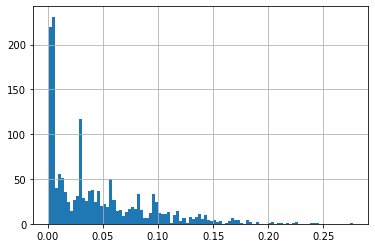

In [37]:
final_df['prediction_wth_prob_no'].hist(bins=100) # minority class

In [65]:
threshold = 0.105
prop = (len(final_df[final_df['prediction_wth_prob_no'] > threshold])/len(final_df))*100
print(f'{str(round(prop,3))}% of cases are above {str(threshold)}')

10.195% of cases are above 0.105


prediction_wth
yes    1589
dtype: int64


Text(0, 0.5, 'count')

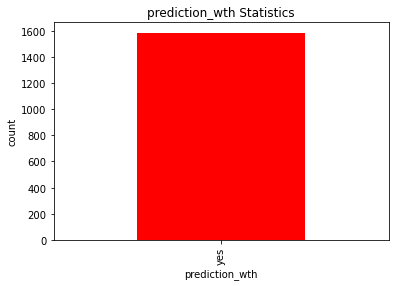

In [30]:
print(final_df.groupby('prediction_wth').size())
colors = ['red', 'green']
wth_plot = final_df.groupby('prediction_wth').size()\
        .plot(kind='bar',title='prediction_wth Statistics', color = colors)
wth_plot.set_ylabel('count')

## Select tweets for sample

Get 150 new tweets, no more than 5 per date, composed of 90% minority class and 10% majority class.<br>
To improve fidelity of model, make the tweets selected majority class fuzzy/unreliable, so model gets better at labeling these.<br>
First, filter into new DFs, one for minority class and one for (fuzzy) majority class.

In [73]:
# set thresholds for minority cases for each myth
# set these as low as possible to capture ~140 tweets likely to fall in minority class
minority_threshold_dis = 0.125 
minority_threshold_rem = 0.155
minority_threshold_wth = 0.105

# filter using threshold
df_dis_minority = final_df[final_df['prediction_dis_prob_yes'] > minority_threshold_dis]
df_rem_minority = final_df[final_df['prediction_rem_prob_yes'] > minority_threshold_rem]
df_wth_minority = final_df[final_df['prediction_wth_prob_no'] > minority_threshold_wth]

# check out results
print('Number of minority cases selected for each myth:')
print(f'{len(df_dis_minority)} for disinfectants')
print(f'{len(df_rem_minority)} for home remedies')
print(f'{len(df_wth_minority)} for weather')

Number of minority cases selected for each myth:
164 for disinfectants
169 for home remedies
162 for weather


In [ ]:
# Note: This function is for later on, once our classifier can better predict minority class.

def check_pred_fuzzy(row, 
                     pred_labels = ['yes', 'no'], 
                     myth_labels = ['dis', 'rem', 'wth']
                     upper_threshold=0.30, 
                     lower_threshold=0.10):
    
    '''
    Checks whether prediction is fuzzy/unreliable. Use this to determine if a tweet is worth hand-coding.
    Rationale: by only coding tweets with unreliable labels, we can improve the classifier's ability to detect 'unsure' cases.
    
    Function focuses on this difference: prob(predicted label) - prob(some other label).
    If difference is greater than lower_threshold (minimum for hand-coding of tweet to be possible), 
    but lesser than upper_threshold (maximum for hand-coding to be necessary), then it IS worth coding, so return True. 
    If difference is not between these, then we either it can't be reliably coded, or already have a reliable prediction,
    so we don't need to hand-code --> return False.

    To help select a threshold, ask: To what extent do we want the uncertainty to be, to help inform our sample selection?    
    For example, if a tweet is labeled as POS with 90% prob and NEG 10% --> this is very obvious sample, so don't bother coding.
    On the other hand, if the predictions are 51% NEG and 49 POS, then we need ppl to label this to update our model. 
    If our upper_threshold is 20% (0.20), then if a tweet has 61% NEG 39% POS probabilities, we don't choose it. 
    If some other tweet has prob 59% POS 41% NEG, we do select it for coding.
    
    Args:
        row: row corresponding to tweet, with predictions in format...
        pred_labels: labels for probabilities to use--used for naming columns
        myth_labels: labels for COVID-19 myths to detect--used for naming columns
        upper_threshold: max difference between predicted probs
        lower_threshold: min difference between predicted probs
    
    Returns:
        binary: True if tweet should be hand-coded, otherwise False.
    '''
    
    # TO DO (once we can classify minority class reliably): Update column titles using myth_labels
    
    pred_label = row["prediction"].strip() # get label of prediction for tweet--must be one of those in possible_labels!
    pred_score = float(row["prob_{}".format(pred_label)]) # get probability of predicted label (probably high)
    
    for pred in pred_labels: # Look at each label
        pred = pred.strip() # clean label text
        
        if pred != pred_label: # if this label isn't the predicted one...
            difference = pred_score - float(row["prob_{}".format(pred)]) # ...then look at their difference in probability
            if lower_threshold <= difference <= upper_threshold:
                 # if difference in probs is > lower_threshold but < upper_threshold, then pred is fuzzy and we should code
                return True # worth coding
    
    return False # not worth coding

df_fuzzy = df[df.progress_apply(check_pred_fuzzy, axis=1)] # limit to only fuzzy labels
df_fuzzy.shape

## Get 5 tweets/day for random dates from Apr-Aug, 2020

In [ ]:
# TO DO: write code for this function

def sample_tweets(df, myth, tweets_per_day = 5, sample_size = 150, prop_yes = .9):
    '''
    For tweets in df, randomly samples tweets_per_day tweets until it reaches sample_size.
    
    Args:
        df: has predictions
        myth: which myth
        tweets_per_day: number of tweets to gather per day
        sample_size: number of fresh tweets to classify
        prop_yes: what proportion of tweets in sample should be predicted yes
    Returns:
        sample: 150 new tweets to label by hand
    '''
    
    # code here
    
    # randomly sample
    
    # return sample

In [ ]:
dis_sample = sample_tweets(dis_probs, df)
rem_sample = 
wth_sample = 

In [ ]:
# TO DO: preprocess tweets for MTurk using conservative version of above function: 
# e.g., censoring usernames but not lower-casing, for instance
# Create options to adjust its parameters to do this

## Ken's old code: Filter with tweet IDs

In [ ]:
if len(already_used_input_fp) > 0:
    df_used = pd.concat([
        pd.read_csv(fp.strip(), dtype=str) for fp in already_used_input_fp
    ], ignore_index=True)
    
    already_used_ids = set(df_used["tweet_id"])
else:
    already_used_ids = set()

print("There are {} tweets already used".format(len(already_used_ids)))

df_low = df_low[~df_low["tweet_id"].isin(already_used_ids)]
df_low.shape

## Ken's old code: Take sample with desired ratio of cases

In [ ]:
# Set fraction of cases we want in minority class 
frac_min = 0.9

In [ ]:
df_against = df_low[df_low["prediction"]=="AGAINST"]\
.sample(n=int(n_sample*0.4), random_state=3)

df_favor = df_low[df_low["prediction"]=="FAVOR"]\
.sample(n=int(n_sample*0.4), random_state=3)

df_none = df_low[df_low["prediction"]=="NONE"]\
.sample(n=int(n_sample*0.2), random_state=3)

df_output = pd.concat([df_against, df_favor, df_none], ignore_index=True).sample(frac=1.0, random_state=5445)

df_output.shape


In [ ]:
collections.Counter(df_output["prediction"])

In [ ]:
df_output = df_output[["tweet_id", "text", "created_at", "prediction"]]

In [ ]:
df_output.head(5)

## Save to file

In [ ]:
# Write
# TO DO: Update this part
df_output.to_csv(output_fp,\
    escapechar='\"', \
    quotechar='\"',\
    quoting=csv.QUOTE_ALL,\
    index=False)